##Neural Networks for Facial Keypoint Detection

-- Hank Mushinski and Dan Davies

We decided to take a stab at one of the more complicated current Kaggle competitions: [Detecting keypoints on photographs of faces](https://www.kaggle.com/c/facial-keypoints-detection). While there are multiple methods that can be applied to tackle this problem, the one that most intrigued us going in was neural networks. What we would come to discover is that, at the present, creating and training a neural network has become relatively straightforward. The barrier to entry is low. But improving on a vanilla model is very difficult.

###Theano, Lasagne, and nolearn

Thanks to the resurgence in popularity of neural networks over the last few years, much of the underlying implementation of neural networks has been abstracted away.

Theano is a library that specializes in high level mathematical structures. This package makes it possible to run some operations (especially matrix calculations) on the much-faster GPU.

Lasagne is built on top of Theano. It is an implementation of several types of neural network architecture, focused around objects called layers.

Finally, nolearn is an abstraction of Lasagne. In nolearn, you specify which types of lasagne layers you would like to build and what their characteristics will be. Nolearn abstracts the implementations of, for example, stochastic gradient descent and validation testing.

In [2]:
% matplotlib inline
# base modules
import os
import pickle
from datetime import datetime
import csv
# downloaded modules
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import theano
import theano.tensor as T
import lasagne
import time
from sklearn.utils import shuffle
from numpy import float32
from nolearn.lasagne import NeuralNet 
import pandas as pd 
print 'done'

Couldn't import dot_parser, loading of dot files will not be possible.
done


Using gpu device 0: GeForce GT 750M


###Initial Data Preparation

The training data comes as a csv file containing an identifying column number, 30 columns indicating x-y coordinates of a given facial feature, and a column where each entry is a long string representing pixel values from 0 to 255.

First, we must load the data from csv into Python. For this, we use Pandas.

In [5]:
def load(fname):
    """
    implementation adapted from
    http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/#the-data
    
    """
    df = np.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    return df

train_data = load('../dataraw/training.csv')
test_data = load('../dataraw/test.csv')

In [ ]:
# pickle formatted data frames
with open('normfaces.pkl', 'wb') as pk:
    pickle.dump((train_data, test_data), pk)

In [3]:
# unpickle data
with open('normfaces.pkl', 'rb') as pk:
    train_data, test_data = pickle.load(pk)
print train_data.count()
print
print test_data.count()
print
print 'Complete training data set size:', train_data.dropna().shape[0]

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

As we can see, the training data is inconsistent. None of the features is consistently marked for all 7049 images in the training set. In fact, only 2140 of the faces in the training data have all fifteen keypoints marked. Let's take a look at a couple of them.

In [261]:
# function to make it easy to convert data frames into numpy arrays
def features_to_numpy(df, test=False):
    df = df.dropna()
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32) # conversion for GPU calculation
    
    if not test:
        y = df[df.columns[:-1]].values
        y = y / 96  # scale target coordinates to [0, 1]
        y = y.astype(np.float32)
        return X, y
    return X

complete_train_data, complete_train_labels = features_to_numpy(train_data.dropna())
test_data_np = features_to_numpy(test_data, test=True)

In [86]:
# simple function to help plot keypoints on faces
def plotface(data, labels, n=0, title=''):
    plt.imshow(data[n].reshape(96,96), cmap='gray')
    for crd in [ labels[n][i:i+2]*96 for i in xrange(0,len(labels[n]),2) ] :
        plt.plot(crd[0], crd[1], 'r.')
        plt.xlim((0,96))
        plt.ylim((96,0))
        plt.axis('off')
        plt.title(title)

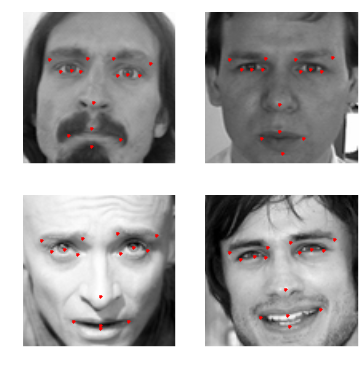

In [203]:
plt.figure(1, figsize=(6,6))
plt.subplot(221)
plotface(complete_train_data, complete_train_labels, n=0)
plt.subplot(222)
plotface(complete_train_data, complete_train_labels, n=1000)
plt.subplot(223)
plotface(complete_train_data, complete_train_labels, n=2000)
plt.subplot(224)
plotface(complete_train_data, complete_train_labels, n=2139)

We can see that the faces are mostly going to be centered in the image, but they may differ quite significantly in angle, depth, and features (e.g. moustaches, sunglasses, shape of mouth, etc)

One naive approach to the Kaggle competition, then, is to take the average of all the facial keypoint positions and submit that for every test answer. This is what an average face from this dataset looks like (average of each pixel in set).

![](really-average-face copy.png)

That's pretty creepy.

####Baseline Kaggle Submission:####
[Score: 3.96420, Rank: 55](https://www.kaggle.com/c/facial-keypoints-detection/leaderboard)

But we're on the board!

###Basic Neural Networks

While this baseline solution can get us pretty far, getting a truly good score requires much more precision. For this purpose, neural networks are a very attractive option. Networks with multiple layers are capable of estimating nonlinear decision boundaries, which makes them ideal for the sort of analysis we are doing here.

We experimented with several types of neural networks, starting with vanilla dense layers. For these experiments, we used only the faces that had completely identified features. While reducing our data this much is suboptimal, the smaller data set trains more quickly and therefore allows us to explore with relative ease and efficiency.

Let's start with a vanilla network.

In [220]:
# helper method to show results of training
def lossplot(net, title):
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.legend()
    plt.grid()
    plt.yscale("log")
    plt.title(title + '\nBlue = training loss | Green = validation loss')
    plt.show()

In [36]:
basic_net = NeuralNet(
    layers=[  
        ('input', lasagne.layers.InputLayer),
        ('dense1', lasagne.layers.DenseLayer),
        ('output', lasagne.layers.DenseLayer),
        ],

    input_shape=(None, 9216),
    dense1_num_units=300, # one layer with 300 nodes

    output_nonlinearity=None,
    output_num_units=30,

    update_learning_rate=theano.shared(np.float32(.01)),

    regression=True,  
    max_epochs=1000,  
    verbose=True,
    )

In [61]:
basic_net.fit(complete_train_data, complete_train_labels)

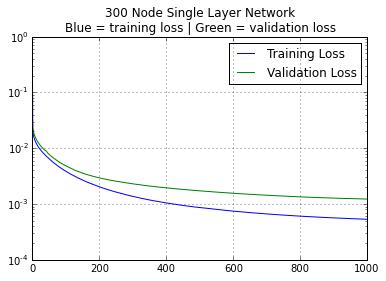

In [109]:
lossplot(basic_net, '300 Node Single Layer Network')

.00123 validation loss doesn't sound too bad, but when we put the result into Kaggle we see that we actually haven't improved on our naive model at all. Kaggle scores this entry 4.463378, well below our benchmark of 3.96.

While adding more epochs looks like it would have led to a continued validation accuracy, the slope of the curve indicates that it would likely not have led to a validation accuracy below 10^-3.

But how about multiple layers?

In [49]:
basic_net_2 = NeuralNet(
    layers=[  
        ('input', lasagne.layers.InputLayer),
        ('dense1', lasagne.layers.DenseLayer),
        ('dense2', lasagne.layers.DenseLayer),
        ('output', lasagne.layers.DenseLayer),
        ],

    input_shape=(None, 9216),
    dense1_num_units=300, # one layer with 300 nodes
    dense2_num_units=300, # one layer with 300 nodes

    output_nonlinearity=None,
    output_num_units=30,

    update_learning_rate=theano.shared(np.float32(.01)),

    regression=True,  
    max_epochs=1000,  
    verbose=True,
    )

In [59]:
basic_net_2.fit(complete_train_data, complete_train_labels)

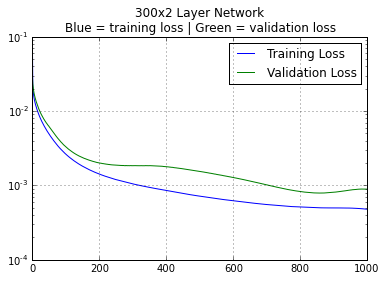

In [110]:
lossplot(basic_net_2, '300x2 Layer Network')

Adding a second layer had several effects. First, the model reached lower scores much more quickly, and did result in a validation loss of 8.1x10^-4. However, after about 900 iterations the model started to overfit. You can see that while the training loss continues to decrease, validation loss begins to increase again. The model was becoming less general.

In order to deal with this tendency to overfit, we will add 'Drop Layers.'

'The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much. During training, dropout samples from an exponential number of different “thinned” networks... This significantly reduces overfitting and gives major improvements over other regularization methods.' - [Srivastava, et al. June 2014](http://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)

In [55]:
basic_net_drop = NeuralNet(
    layers=[  
        ('input', lasagne.layers.InputLayer),
        ('dense1', lasagne.layers.DenseLayer),
        ('drop1', lasagne.layers.DropoutLayer),
        ('dense2', lasagne.layers.DenseLayer),
        ('drop2', lasagne.layers.DropoutLayer),
        ('output', lasagne.layers.DenseLayer),
        ],

    input_shape=(None, 9216),
    dense1_num_units=300, # one layer with 300 nodes
    drop1_p=.5,
    dense2_num_units=300, # one layer with 300 nodes
    drop2_p=.5,
    
    output_nonlinearity=None,
    output_num_units=30,

    update_learning_rate=theano.shared(np.float32(.01)),

    regression=True,  
    max_epochs=1000,  
    verbose=True,
    )

In [60]:
basic_net_drop.fit(complete_train_data, complete_train_labels)

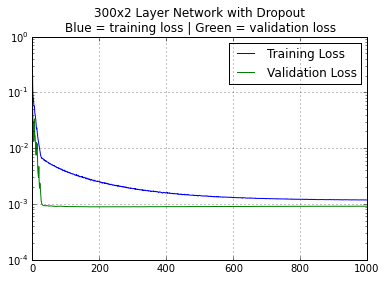

In [112]:
lossplot(basic_net_drop, '300x2 Layer Network with Dropout')

The dropout layers have a dramatic effect. Validation loss plummets and at no point does the model begin to severely overfit. However, we finish with a final validation loss of 9.1x10^-4, which is not an improvement over the same network without dropout. It seems that while the network is not as prone to mistakes like overfitting, we have reached a plateau for this method. Attempts to add more similar layers and let the model run for more epochs resulted in marginal improvements in validation accuracy, but ultimately did not make a large difference in performance.

Let's take a look at some predictions to see how we have done.

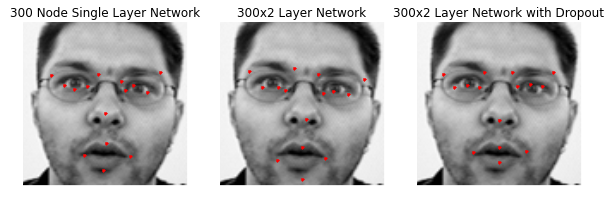

In [273]:
basic_predict = basic_net.predict(test_data_np)
basic_2layer_predict = basic_net_2.predict(test_data_np)
basic_2layer_drop_predict = basic_net_drop.predict(test_data_np)

k = 10
plt.figure(1, figsize=(10,6))
plt.subplot(131)
plotface(test_data_np, basic_predict, n=k, title='300 Node Single Layer Network')
plt.subplot(132)
plotface(test_data_np, basic_2layer_predict,n=k, title='300x2 Layer Network')
plt.subplot(133)
plotface(test_data_np, basic_2layer_drop_predict,n=k, title='300x2 Layer Network with Dropout')

Despite having a worse validation loss score, it's clear that the 2 layer network with dropout has generalized the best to the task. Still, we have not yet cracked our Kaggle score from our naive prediction using mean values. This new best still scores us at 4.29 on Kaggle.


###Convolutional Neural Networks

A convolutional neural network doesn't treat our faces as a single vector of pixel values. Instead it requires the image to be in matrix format. A convolutional layer consists of nodes whose values are derived from a combination of the nodes that surround them in the input layer. By condensing pixels, the convolutional layer is able to learn traits of an 'area' in the image rather than the traits of a single pixel. [Convolutional Neural Networks](http://ufldl.stanford.edu/tutorial/supervised/FeatureExtractionUsingConvolution/)

Daniel Nouri, author of nolearn, published an [excellent description](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) of the application of this technique to solve facial keypoint recognition. We toyed with his techniques, but ultimately moved on because we found it unlikely we would be able to improve on his score using the same tools. So we moved next to the hottest topic in machine learning.

###Recurrent Neural Networks

Recurrent neural networks have a fundamental difference from densely connected layers and convolutional layers: While the others can only move forward, recurrent layers have a feedback loop. They have been called [unreasonably effective](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), and after working with them here it is easy to see why.

Because of their unique structure, recurrent networks process data differently than others. Recurrent networks take inputs sequentially. This basically means the weights for each node are influenced by all the nodes that preceded it.

Let's take a look at what a *very* simple recurrent network can do.

In [179]:
recurrent_net = NeuralNet(
    layers=[  
        ('input', lasagne.layers.InputLayer),
        ('rnn1', lasagne.layers.RecurrentLayer),
        ('drop1', lasagne.layers.DropoutLayer),
        ('output', lasagne.layers.DenseLayer),
        ],

    input_shape=(None, 1, 96, 96),
    rnn1_num_units=400,
    drop1_p=.5,

    output_nonlinearity=None,
    output_num_units=30,

    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=theano.shared(np.float32(.01)),
    update_momentum=theano.shared(np.float32(.9)),

    regression=True,  
    max_epochs=2000,  
    verbose=True,
    )

In [280]:
recurrent_net.fit(complete_train_data.reshape(-1,1,96,96), complete_train_labels)

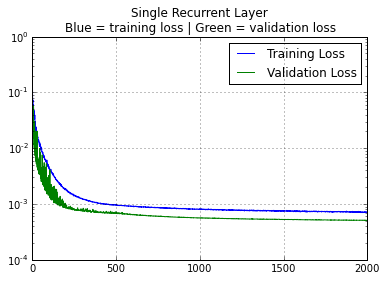

In [181]:
lossplot(recurrent_net, 'Single Recurrent Layer')

Excellent! With a minimum validation loss of 5.1x10^-4, we've improved on the best score we got while training simple dense layers by 46%!

How much better can we get with two layers?

In [150]:
recurrent_net_2 = NeuralNet(
    layers=[  
        ('input', lasagne.layers.InputLayer),
        ('rnn1', lasagne.layers.RecurrentLayer),
        ('drop1', lasagne.layers.DropoutLayer),
        ('rnn2', lasagne.layers.RecurrentLayer),
        ('drop2', lasagne.layers.DropoutLayer),
        ('output', lasagne.layers.DenseLayer),
        ],

    input_shape=(None, 1, 96, 96),
    rnn1_num_units=400,
    drop1_p=.5,

    rnn2_num_units=400,
    drop2_p=.5,
    
    output_nonlinearity=None,
    output_num_units=30,

    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=theano.shared(np.float32(.01)),
    update_momentum=theano.shared(np.float32(.9)),

    regression=True,  
    max_epochs=2000,  
    verbose=True,
    )

In [154]:
recurrent_net_2.fit(complete_train_data.reshape(-1,1,96,96), complete_train_labels)

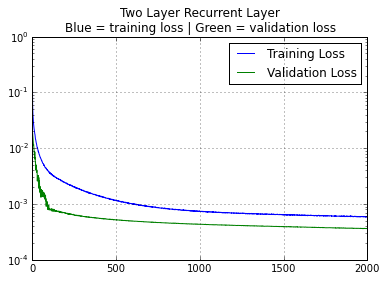

In [159]:
lossplot(recurrent_net_2, 'Two Layer Recurrent Layer')

Let's examine the predictions to see how they have improved.

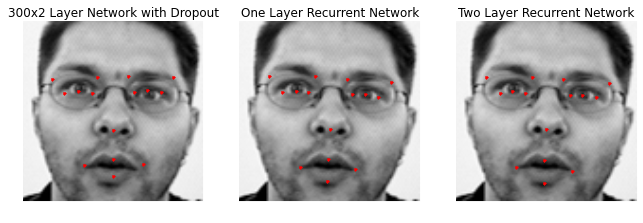

In [274]:
rnn1p = recurrent_net.predict(test_data_np.reshape(-1,1,96,96))
rnn2p = recurrent_net_2.predict(test_data_np.reshape(-1,1,96,96))

k=10
plt.figure(1, figsize=(11,6))
plt.subplot(131)
plotface(test_data_np, basic_2layer_drop_predict,n=k, title='300x2 Layer Network with Dropout')
plt.subplot(132)
plotface(test_data_np, rnn1p,n=k, title='One Layer Recurrent Network')
plt.subplot(133)
plotface(test_data_np, rnn2p,n=k, title='Two Layer Recurrent Network')

It is readily apparent from the results that the two layer recurrent network is a vast improvement over the generic dense layers from before and the single recurrent layer. Noticeable improvements were made in eye and lip location.

But how did we do in the competition?

We've surpassed our naive mean solution! *The Kaggle score for this entry was 3.55, an improvement of .41 in a single leap! We're now in 44th place.* The minimum validation loss dropped all the way to 3.7x10^-4.

While we toyed with other types of recurrent networks, including Long-term Short-term Memory networks, ultimately we decided to stick with these simpler two-layer recurrent networks because they were much faster to train. In order to continue to improve our Kaggle score, we turned to the input data.


###A Network for Every Feature

Earlier when building the training dataset, we threw out almost 5000 images because they did not have complete feature labels. Now that we have identified a model that quickly achieves a remarkable level of accuracy, we take steps to account for all of this missing data.

While we cannot train a model on the full dataset with NAN values for many entries, we can split the training data by feature, and train one model for each feature. So in effect we increase our training data for the center of the left eye from 2140 to 7039 samples. The increase in data helps generalize the model to the test data, while the model outputs are reduced to 1 x-y pair rather than 15.

In [248]:
# generator function that yields x-y pairs for each identified facial feature as pandas data frame
def get_features():
    for i, col in enumerate(train_data.columns):
        if i % 2 == 0:
            if col != 'Image':
                df = train_data.iloc[:,[i,i+1,30]].copy() # make a copy of the columns
                yield df.dropna() # drop na values before yielding data

feats= get_features()
featurenames = []
for i, col in enumerate(train_data.columns):
    if i % 2 == 0: # skip every other column
        if col != 'Image':
            featurenames.append(col[:-2])
            # define variables containing training data such as left_eye_center, nose_tip, etc
            exec "%s = next(feats)" % col[:-2]
print 'Left Eye Center training dataset', left_eye_center.shape
print 'Mouth Left Corner training dataset', mouth_left_corner.shape

Left Eye Center training dataset (7039, 3)
Mouth Left Corner training dataset (2269, 3)


In [231]:
# turn training dataset dataframes to numpy arrays for training
featurelist = []
for feature in featurenames:
    exec "%s_tr, %s_lb = features_to_numpy(%s)" % (feature, feature, feature)
    exec '%s=None' % feature # force garbage collection on unused variable, free up memory
    featurelist.append('%s_tr'%feature)

First, we define the standard network structure that we are going to apply to each feature. In this case, we also add an AdjustVariable class that will increase or decrease a specificied metaparameter (such as learning rate) in a linear fashion as epochs increase.

The local_net() function simply wraps the neural network implementation to make it easier to initialize a new network during a loop.

In [174]:
# implementation of AdjustVariable adapted from
# http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

def local_net(epochs=2000):
    return NeuralNet(
    layers=[  
        ('input', lasagne.layers.InputLayer),
        ('rnn2', lasagne.layers.RecurrentLayer),
        ('drop2', lasagne.layers.DropoutLayer),
        ('rnn3', lasagne.layers.RecurrentLayer),
        ('drop3', lasagne.layers.DropoutLayer),
        ('output', lasagne.layers.DenseLayer),
        ],

    input_shape=(None, 1, 96, 96),
    rnn2_num_units=400,
    rnn2_nonlinearity=lasagne.nonlinearities.leaky_rectify, # nonlinearity slightly improves validation performance
    drop2_p=.5,
    
    rnn3_num_units=400,
    rnn3_nonlinearity=lasagne.nonlinearities.leaky_rectify,
    drop3_p=.5,

    output_nonlinearity=None,
    output_num_units=2,

    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=theano.shared(np.float32(.01)),
    update_momentum=theano.shared(np.float32(.9)),
    
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.01, stop=0.001),
        AdjustVariable('update_momentum', start=0.9, stop=0.99)
        ],

    regression=True,  
    max_epochs=epochs,  
    verbose=True,
    )

Next we run the network. Because this will take quite a while to run, and is prone to crashing the computer if the GPU is overtaxed, we take care to save the networks as soon as they are done training.

In [191]:
import pickle
def train_all_features(featurenames, suffix=''):
    finished = []
    for feature in featurenames:
        net = local_net()
        exec "data = %s_tr" % feature
        exec "labels = %s_lb" % feature
        order = np.random.permutation(data.shape[0]) # randomly order data before training
        input_data, input_labels = data[order].reshape(-1,1,96,96), labels[order]
        try:
            net.fit(input_data, input_labels)
            net.save_params_to(feature + '_w' + suffix + '.pkl') # save network parameters
            with open(feature + '_net' + suffix + '.pkl','wb') as pkl:
                pickle.dump(net, pkl) # pickle network object (big file)
        except KeyboardInterrupt: # in the event of an early cancellation, save params and try to move on
            net.save_params_to(feature + '_w' + suffix + '.pkl')
            with open(feature + '_net' + suffix + '.pkl','wb') as pkl:
                pickle.dump(net, pkl)
            continue
        finished.append(feature)
        print finished
        
    return finished

print train_all_features(featurelist)

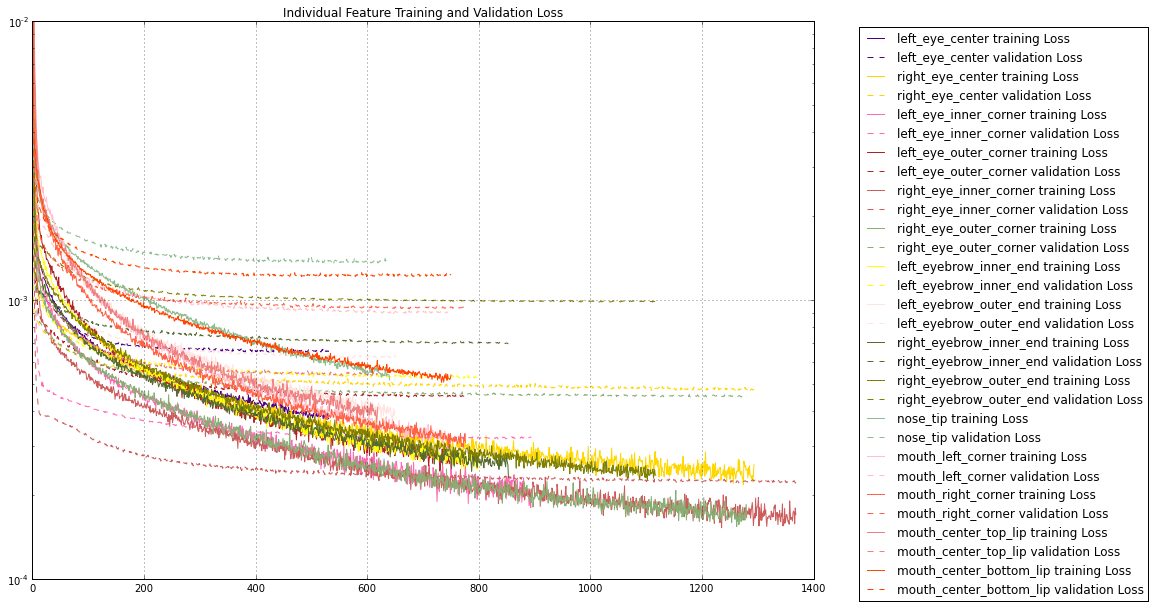

In [235]:
# plot individual feature training loss
import matplotlib.colors as colors
plt.figure(1, figsize=(14,10))
for color, name in zip(colors.cnames, featurenames):
    with open(name+'_net.pkl' ,'rb') as pk:
#         print name+'_net.pkl'
        net = pickle.load(pk)
        train_loss = np.array([i["train_loss"] for i in net.train_history_])
        valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
        plt.plot(train_loss, label=name +' training Loss', color=color)
        plt.plot(valid_loss, label=name +' validation Loss', color=color, linestyle='dashed')
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid()
plt.yscale("log")
plt.ylim(10**-4, 10**-2)
plt.title('Individual Feature Training and Validation Loss')
plt.show()

It's plain from this chart that some features are predicted much better on their own than in a grouping with the rest. For example, right eye inner corner validation loss dropped close to 2x10^-4.

How do we do when we put them all back together?

In [216]:
# after training, all features are combined into a prediction by loading up pickled weights and applying them to the test data
import pickle
def build_prediction(data, nets):
    predictions = None
    for saved_net in nets:
        print saved_net
        net = local_net()
        net.load_params_from(saved_net+'.pkl')
        if predictions is not None:
            predictions = np.concatenate((predictions, net.predict(data)), axis=1)
        else:
            predictions = net.predict(data)
    
    return predictions

test_local = build_prediction(data= test_data_np.reshape(-1,1,96,96), nets=[f+'_w' for f in featurenames])

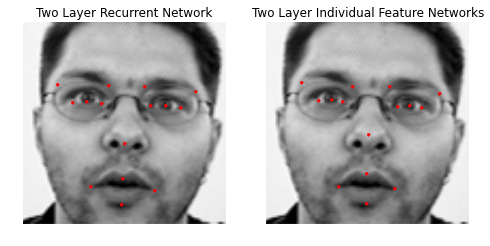

In [275]:
k=10
plt.figure(1, figsize=(8,6))
plt.subplot(121)
plotface(test_data_np, rnn2p,n=k, title='Two Layer Recurrent Network')
plt.subplot(122)
plotface(test_data_np, test_local, n=k, title='Two Layer Individual Feature Networks')

The improvements are small to the naked eye, but close inspection reveals how much the prediction has improved. In the photo above, specifically the top lip, nose, and eye corners are all far more accurate than the single network trained on the entire image.

But how did we do in the competition?

####Kaggle score: 2.86! Rank 17!

With this model improvement, we jump 37 places in the rankings!

However we're not quite done yet. The data we've been entering so far has simply been slightly modified training data. But the test set contains many images that have a slight rotation or blur, and in each of the models we built, the model tended to overfit while the validation score stopped improving. We need a way to make these models more general, in order to better capture the facial keypoints in the more different test cases.

###Improving Model Generalization with Feature Engineering

As it turns out, we can improve model generality by tweaking the training data.

Let's start by reversing the images.

In [257]:
# takes a dataframe with image data, reverses the image and assigns appropriate labels,
# then returns a combination of the original data frame and reversed data frame
def reverse_feature(feature, additional):
    if additional is None:
        reversed_feature = feature.copy()
    else:
        reversed_feature = additional.copy()
        reversed_feature.columns = list(feature.columns)

    reversed_feature.iloc[:,0] = 96 - reversed_feature.iloc[:,0]
    reversed_feature['Image'] = reversed_feature['Image'].apply(lambda image: image.reshape(96,96)[:, ::-1].reshape(9216) )
    return feature.append(reversed_feature)

revlist=[]
for feat in featurenames:
    if feat[:5] == 'left_':
        add = 'right_' + feat[5:]
        execstring='%s_rev = reverse_feature(%s, %s)' %( feat, feat, add )
        exec execstring
    elif feat[:5] == 'right':
        add = 'left' + feat[5:]
        execstring='%s_rev = reverse_feature(%s, %s)' %( feat, feat, add )
        exec execstring
    elif feat[:10] == 'mouth_left':
        add = 'mouth_right' + feat[10:]
        execstring='%s_rev = reverse_feature(%s, %s)' %( feat, feat, add )
        exec execstring
    elif feat[:10] == 'mouth_righ':
        add = 'mouth_lef' + feat[10:]
        execstring='%s_rev = reverse_feature(%s, %s)' %( feat, feat, add )
        exec execstring
    else:
        exec '%s_rev = reverse_feature(%s, None)' %( feat, feat )
    revlist.append(feat+'_rev')

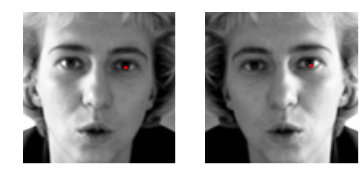

In [258]:
# demonstrate reversed face
train_data_rev, train_labels_rev = features_to_numpy(left_eye_center_rev)
plt.figure(1, figsize=(6,4))
plt.subplot(121)
plotface(train_data_rev, train_labels_rev, n=1)
plt.subplot(122)
plotface(train_data_rev, train_labels_rev, n=7040)

Additionally, we can blur the images. This should improve model performance on blurry or pixelated test data.

In [259]:
from scipy.ndimage.filters import gaussian_filter

def blur_training_data(feature):
    blurred_feature = feature.copy()
    blurred_feature['Image'] = blurred_feature['Image'].apply(lambda image: gaussian_filter(image.reshape(96,96),3).reshape(9216) )
    return feature.append(blurred_feature)
    
blurlist = []
for feat in featurenames:
    exec '%s_blur = blur_training_data(%s)' % (feat, feat)
    blurlist.append('%s_blur' % feat)

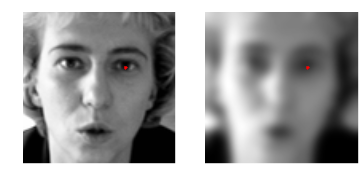

In [262]:
# demonstrate blurred face
train_data_blur, train_labels_blur = features_to_numpy(left_eye_center_blur)
plt.figure(1, figsize=(6,4))
plt.subplot(121)
plotface(train_data_blur, train_labels_blur, n=1)
plt.subplot(122)
plotface(train_data_blur, train_labels_blur, n=7040)

By applying both transformations at the same time, we have effectively quadrupled our training data and increased the variability that the network will have to account for when it calculates weights. Next we re-train our feature networks with the expanded data sets.

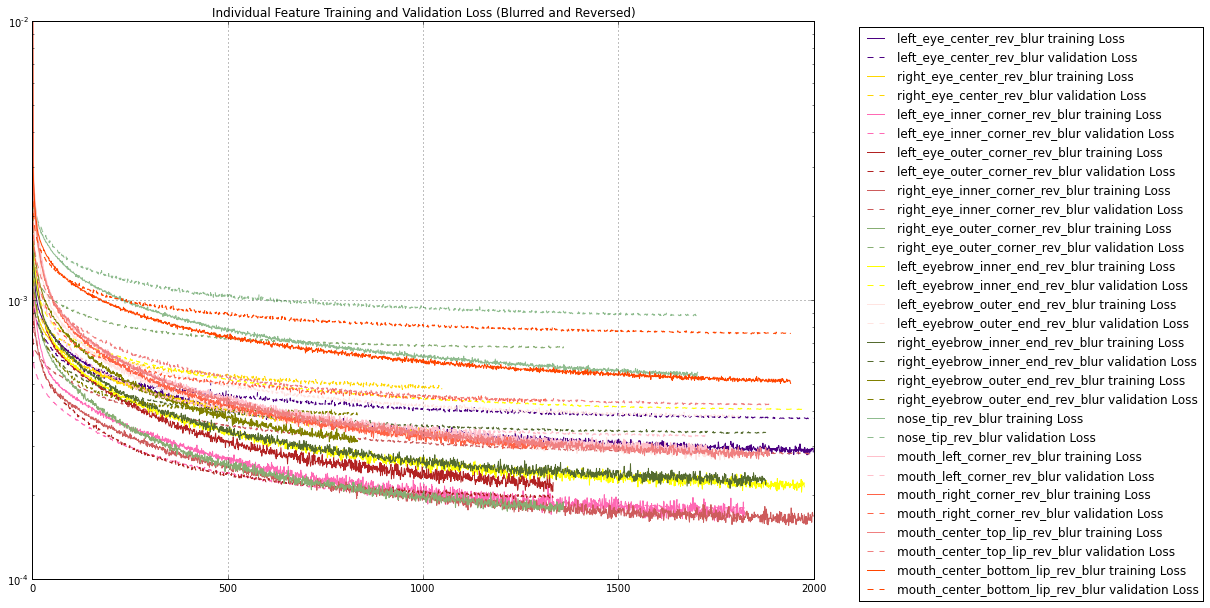

In [264]:
# plot individual feature training loss
import matplotlib.colors as colors
plt.figure(1, figsize=(14,10))
for color, name in zip(colors.cnames, [f+'_rev_blur' for f in featurenames]):
    with open(name+'_net_reversed_blur.pkl' ,'rb') as pk:
        net = pickle.load(pk)
        train_loss = np.array([i["train_loss"] for i in net.train_history_])
        valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
        plt.plot(train_loss, label=name +' training Loss', color=color)
        plt.plot(valid_loss, label=name +' validation Loss', color=color, linestyle='dashed')
    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.grid()
plt.yscale("log")
plt.ylim(10**-4, 10**-2)
plt.title('Individual Feature Training and Validation Loss (Blurred and Reversed)')
plt.show()

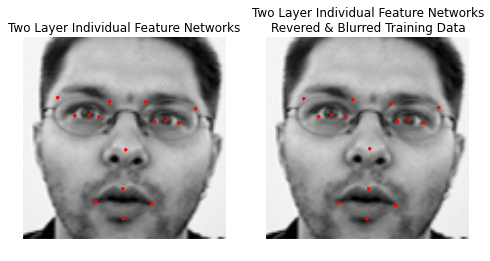

In [279]:
with open('local_predictions_data.pkl','rb') as pk:
    _, test_local_revblur = pickle.load(pk)
    
k=10
plt.figure(1, figsize=(8,6))
plt.subplot(121)
plotface(test_data_np, test_local, n=k, title='Two Layer Individual Feature Networks')
plt.subplot(122)
plotface(test_data_np, test_local_revblur, n=k, title='Two Layer Individual Feature Networks\nRevered & Blurred Training Data')

It doesn't look like much, but this method did substantially improve our model.

In the chart above, it's clear that the additional data helped lower the plateau for validation loss on each of the features. While the models ultimately still overfitted to the training data, the training data contained more variation than in the earlier model, and so the fit is slightly better on the test data.

####Final Kaggle Score: 2.69037 - Final Rank: 16

##Conclusions

While we were able to get a decent score on the leaderboard, this method was especially challenging to master. More than anything, the training time was much slower than other machine learning techniques, and the barrier to entry was high. As a result, iteration came at a snail's pace, and with my computer fighting just to cool off the processors, it was unusable for further research while models were training.

While some of our methods never made it to the final entry, we saw unfulfilled promise in Long-Short Term Memory recurrent networks and combinations of convolutional layers and recurrent layers within the same model. Unfortunately we simply did not have the time to train these more complex models sufficiently to beat our best score.

Given more time and computing power, our next steps would be to iterate on creating more training data. One method that showed promise was 'binarizing' the pixels such that they were either black or white. We made attempts to introduce rotational variance by flipping faces sideways or upside down. This, however, seemed to force the model predictions into the center of the picture and ultimately did not prove worthwhile.

While our final model was not very complex, the main benefit it brought was that it was fast enough to train 15 separate models with up to 2000 epochs a piece in under 15 hours, and accurate enough to provide a solid estimate despite its relative simplicity.

###Appendix

Here are some image processing techniques we implemented but did not incorporate into the model due to training time constraints.

In [291]:
### Imaging functions for emphasizing features

%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pnd

import numpy as np
import random
os.getcwd()
import numpy as np
from scipy import ndimage

def hipass(image,gaussrad,dilrat):
    # 
    # A derivative of gaussian (suggested radii of 0.5) to get edges
    # followed by a morphological dilate to widen the effect and pick up extra pixels on edges
    # This can be used as a mask for 

    timg = np.copy(image).reshape(96,96)
    
    gradim = ndimage.gaussian_gradient_magnitude(timg,gaussrad)
    
    digradim= ndimage.morphology.grey_dilation(gradim,size=(dilrat,dilrat))
    
    return digradim.flatten()
    

def thresh(image,thr):
    
    timg = np.copy(image).reshape(96,96)
    
    timg[timg<thr]=0
    
    timg[timg>=thr]=255
    
    return timg.flatten()
    
def neg(image):
    
    timg =np.copy(image).reshape(96,96)
    
    timg = 255-timg
    
    return timg.flatten()


def binarize(image):
    
    # approximate half the pixels set to 255 , half to 0
    
    timg = np.copy(image)
    
    thr = np.median(timg)
    
    return thresh(timg,thr).flatten()

def cfar(image,orad,irad):
    
    timg = np.copy(image).reshape(96,96)
    
    im = ndimage.gaussian_filter(timg,irad)
    den = ndimage.gaussian_filter(timg,orad) - im
    
    return 25*abs((timg-im)/abs(den)).flatten()+127 

def close(image,rad):
    
    timg = np.copy(image).reshape(96,96)

    return ndimage.morphology.grey_closing(timg,rad).flatten() 

    
def show(image,orad,irad,idil,thr):
    
    # This routine uses cfar for edge detection, dilation to 
    # espand the region and then threshold for using as mask
    # somewhat optimum values for parameters are 4,1,4,196
    # best overlay effect plot 0.75*original + 0.25*this image
    timg= np.copy(image).reshape(96,96)
    
    cfarimg = cfar(timg,orad,irad).reshape(96,96)
    dilimg  = ndimage.grey_dilation(cfarimg,size=(idil,idil))
    
    if thr > 0:
        rimg = thresh(dilimg,thr)
    else:
        rimg = dilimg.flatten()
        
    return rimg

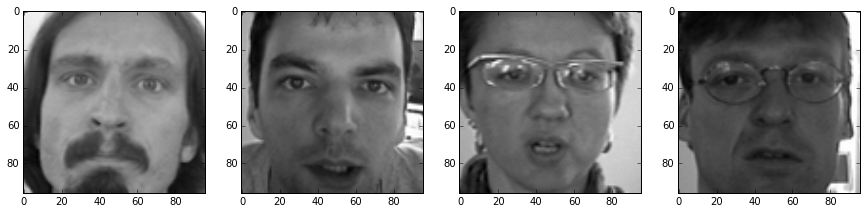

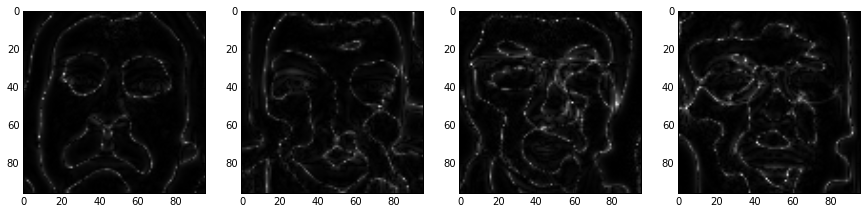

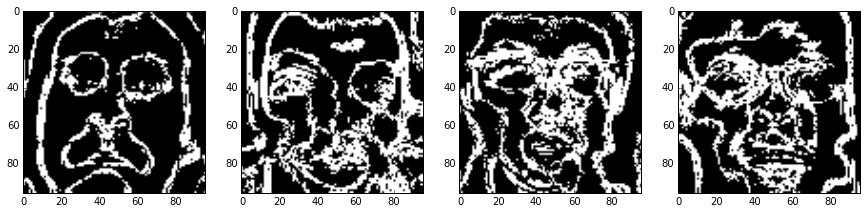

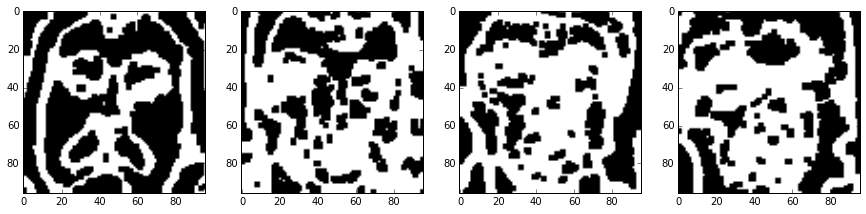

In [292]:
# grayscale regular
fig = plt.figure(figsize=(15,30))
plt.subplot(141)
plt.imshow(complete_train_data[0].reshape(96,96), cmap='gray')
plt.subplot(142)
plt.imshow(complete_train_data[5].reshape(96,96), cmap='gray')
plt.subplot(143)
plt.imshow(complete_train_data[10].reshape(96,96), cmap='gray')
plt.subplot(144)
plt.imshow(complete_train_data[15].reshape(96,96), cmap='gray')

# 
fig = plt.figure(figsize=(15,30))
plt.subplot(141)
plt.imshow(np.log(abs(cfar(complete_train_data[0],7,3))).reshape(96,96), cmap='gray')
plt.subplot(142)
plt.imshow(np.log(abs(cfar(complete_train_data[5],7,3))).reshape(96,96), cmap='gray')
plt.subplot(143)
plt.imshow(np.log(abs(cfar(complete_train_data[10],7,3))).reshape(96,96), cmap='gray')
plt.subplot(144)
plt.imshow(np.log(abs(cfar(complete_train_data[15],7,3))).reshape(96,96), cmap='gray')

#
fig = plt.figure(figsize=(15,30))
plt.subplot(141)
plt.imshow(thresh(cfar(complete_train_data[0],7,3),177).reshape(96,96), cmap='gray')
plt.subplot(142)
plt.imshow(thresh(cfar(complete_train_data[5],7,3),177).reshape(96,96), cmap='gray')
plt.subplot(143)
plt.imshow(thresh(cfar(complete_train_data[10],7,3),177).reshape(96,96), cmap='gray')
plt.subplot(144)
plt.imshow(thresh(cfar(complete_train_data[15],7,3),177).reshape(96,96), cmap='gray')

#
fig = plt.figure(figsize=(15,30))
plt.subplot(141)
plt.imshow(close(thresh(cfar(complete_train_data[0],7,3),160),3).reshape(96,96), cmap='gray')
plt.subplot(142)
plt.imshow(close(thresh(cfar(complete_train_data[5],7,3),160),3).reshape(96,96), cmap='gray')
plt.subplot(143)
plt.imshow(close(thresh(cfar(complete_train_data[10],7,3),160),3).reshape(96,96), cmap='gray')
plt.subplot(144)
plt.imshow(close(thresh(cfar(complete_train_data[15],7,3),160),3).reshape(96,96), cmap='gray')